In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [271]:
%run -i functions.py

Functions Loaded!


In [272]:
av_raw = pd.read_csv("Availability_for_ML.csv")
fa_nov = pd.read_csv("SCS_Alerts_NOV.csv")
fa_oct = pd.read_csv("SCS_Alerts_OCT.csv")

data = pre_process_av_and_fa_oct_nov(av_raw,fa_oct,fa_nov,remove_same_location_faults = True)

fa = data['faults']
av = data['availability']

fa = floor_time(fa,'Entry time',floor_units='H',shift = 10,shift_units='m') 

fa = faults_aggregate_and_pivot(df=fa,
                                time_col='Entry time',
                                fault_level='Module',
                                agg_col='Duration',
                                agg_type='count',#can use mean/count/sum
                                quadrant=None,# by default all quadrants are kept
                                break_durations=False)

fa  = weight_hours(df=fa, weights = [1])

av = availability_quadrant_mean(df=av,
                                time_col='Datetime',
                                level = 'Quadrant', # by default all data is kept
                                selection = 13) 

df = merge_av_fa(av_df=av,
                 fa_df=fa,
                 min_date=None, 
                 max_date=None) #specify min/max date if you want to filter data by date


#remove columns with only zeros (faults that did not happen in this period of time or quadrant)
df = df.loc[:, (df != 0).any(axis=0)]
df.head()

Quadrants Assigned
Modules Assigned
duplicated location faults removed - max duration kept
Fault and availability data pre-processed
Time shifted by 10m
Faults aggregated and pivoted
Previous Hours Weighted
Output will contain data only for Module: 13
Availability data aggregated
Availability and fault datasets merged


,Datetime,Downtime,1,10,11,12,13,14,15,17,...,C07 External,C08 External,C09 External,C11 External,C12 External,C13 External,C14 External,Destacker,ECB,Outer Loop
0,2020-10-16 06:00:00,0.409765,3.0,3.0,1.0,8.0,2.0,3.0,7.0,4.0,...,3.0,12.0,5.0,4.0,0.0,8.0,3.0,14.0,25.0,17.0
1,2020-10-16 07:00:00,0.180526,6.0,3.5,7.5,9.0,2.0,0.0,5.0,2.0,...,5.0,19.0,8.0,1.0,2.0,8.0,8.0,10.0,4.0,37.0
2,2020-10-16 08:00:00,0.164189,7.0,2.0,3.5,24.0,1.0,0.0,4.0,3.0,...,3.0,26.0,5.0,5.0,6.0,10.0,4.0,6.0,8.0,35.0
3,2020-10-16 09:00:00,0.180914,19.0,3.0,5.5,10.0,1.0,2.0,8.0,9.0,...,4.0,10.0,4.0,0.0,9.0,13.0,3.0,15.0,7.0,45.0
4,2020-10-16 10:00:00,0.344868,9.0,3.0,3.0,14.0,2.0,0.0,6.0,5.0,...,8.0,7.0,9.0,5.0,8.0,16.0,8.0,2.0,14.0,30.0


Feature Importance Ranking: 
 
    Importance       Feature
0    0.154069             2
1    0.082240            20
2    0.044409            19
3    0.043466             7
4    0.041660            12
5    0.041352             9
6    0.037974  C06 External
7    0.035451             3
8    0.034196    Outer Loop
9    0.029870           ECB

Number of Selected Features:8

Regression Metrics: 
 
                   RF  RF Reduced
MAE         0.161678    0.149272
MSE         0.042427    0.033323
RMSE        0.205978    0.182545
MAPE%     133.160000   74.580000
ACC%      -33.160000   25.420000
OOB         0.277828    0.261244
R2_Train    0.903315    0.898683
R2_Pred     0.246956    0.193226

Cross Validation Scores: 
 
       RF R2 Scores  RF Reduced R2 Scores
1         0.190355              0.258183
2         0.280951              0.306329
3         0.229846              0.112844
4         0.042165              0.033526
5        -0.031221             -0.053661
Mean      0.142419             

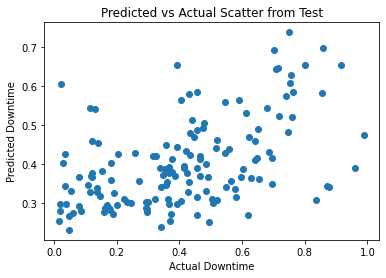

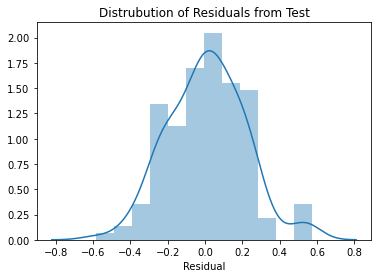

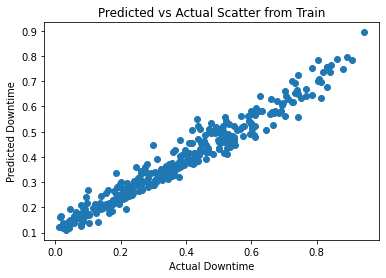

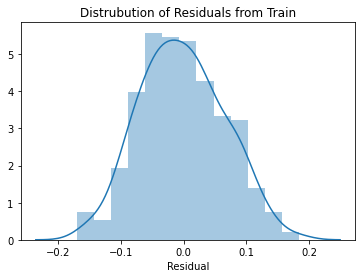

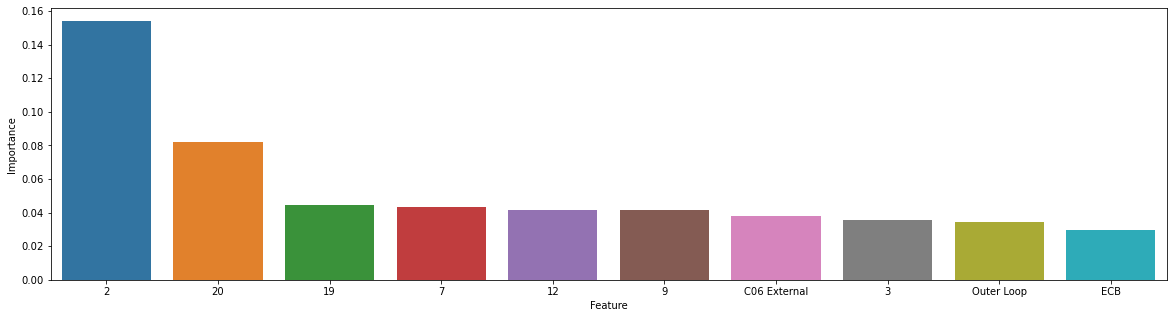

In [273]:
run_model(df, modeltype='RF',num_trees=100,cv=5,select = 'mean',dtree=False)